prompt:  load the parquet fies we created in the other two notebooks and perform
a regression to analyze the relationship between median income of a tract
(independent variable ) and the average download speeds (dependent variable ) in
that tract. You will need to do a spatial join on the two dataset, to locate
each point from the uss_mobile_2022q1 dataset to a census tract, then aggregate
by tract, computing the average or median download speed or upload speed. You
should create an analysis function to parameterize which statistic of central
tendencay we use, and which dependent variable we use. Use statsmodel for the OLS. 

## Updates

[ When you have completed an update, put `[DONE]` in front of it, after the bullet. ]

* [DONE] You do not need to create Points from tile_x and til_y in the uss_mobile dataset, there is already a geometry field. You might have to use shapely.loads to convert that from a string to a geometry, but check first.

* [DONE] Aggregating the joined dataset:  average these fields: ['avg_d_kbps',
  'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms']. sum these
  fields: ['tests', 'devices']. group by: 'GEOID'. There should be only one
  'median_income', and it should be passed through. 



In [39]:
 # Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load configuration
data_dir = None
%run ../../config.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/eric/proj/scratch/WirelessIncome
Data directory: /Users/eric/proj/scratch/WirelessIncome/data


In [40]:
df = pd.read_parquet(data_dir/'merged_2022.parquet')
df.head()

,GEOID,avg_d_kbps_fixed,avg_d_kbps_mobile,tests_fixed,tests_mobile,NAME,population,acs_year,state,county,tract,median_income,STUSPS,county_name,urban_core_type,primary_ruca_desc,primary_dest_code,pop_density
0,01001020100,198218.097274,73227.430357,513.0,35.0,Census Tract 201; Autauga County; Alabama,1865,2022,01,001,020100,60563.0,AL,Autauga County,Metro core,Metropolitan core,58600,467.9
1,01001020200,229213.872727,40949.616667,304.0,25.0,Census Tract 202; Autauga County; Alabama,1861,2022,01,001,020200,57460.0,AL,Autauga County,Metro core,Metropolitan core,58600,1602.7
2,01001020300,243372.740896,128294.737500,375.0,67.0,Census Tract 203; Autauga County; Alabama,3492,2022,01,001,020300,77371.0,AL,Autauga County,Metro core,Metropolitan core,58600,1557.1
3,01001020400,199444.351471,120218.070833,649.0,40.0,Census Tract 204; Autauga County; Alabama,3987,2022,01,001,020400,73191.0,AL,Autauga County,Metro core,Metropolitan core,58600,1722.5
4,01001020501,240464.220486,96485.661310,954.0,60.0,Census Tract 205.01; Autauga County; Alabama,4121,2022,01,001,020501,79953.0,AL,Autauga County,Metro core,Metropolitan core,58600,1804.4


In [41]:
df.avg_d_kbps_mobile = df.avg_d_kbps_mobile.clip(0,1e6)
df.avg_d_kbps_fixed = df.avg_d_kbps_fixed.clip(0, 1e6)

<Axes: >

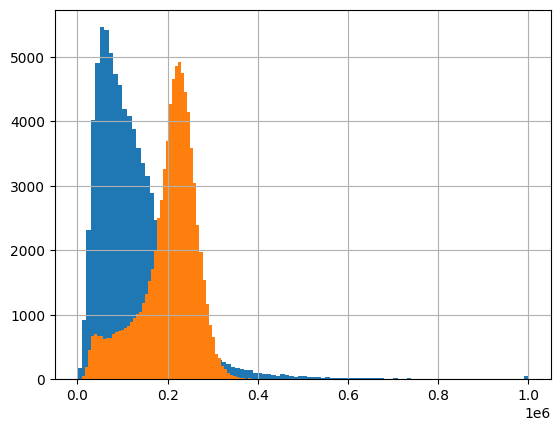

In [42]:
ax = df.avg_d_kbps_mobile.hist(bins=100)
df.avg_d_kbps_fixed.hist(ax=ax, bins=100)
#ax.set_xlim(0, 1_000_000)

                            OLS Regression Results                            
Dep. Variable:      avg_d_kbps_mobile   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     537.7
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          1.44e-118
Time:                        21:26:36   Log-Likelihood:            -1.0559e+06
No. Observations:               82193   AIC:                         2.112e+06
Df Residuals:                   82191   BIC:                         2.112e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.13e+05    722.675    156.398

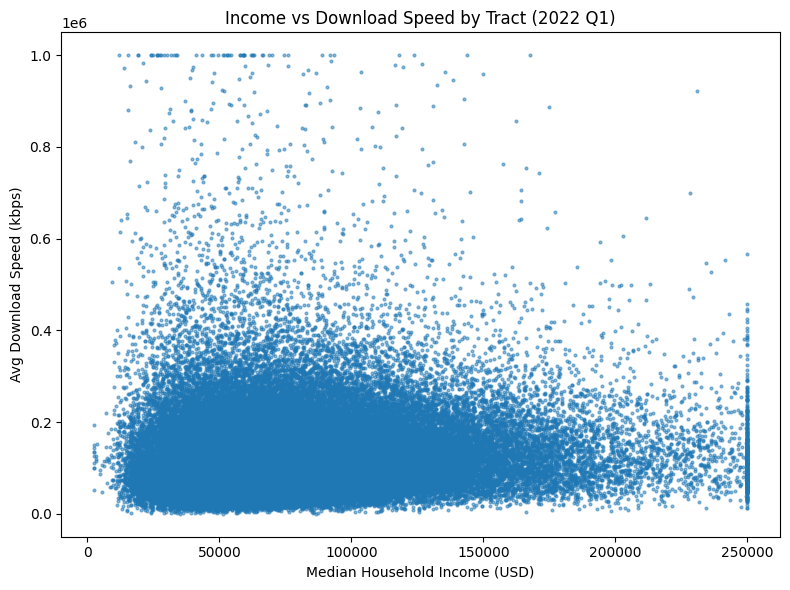

In [43]:
x_var = "median_income"
y_var = "avg_d_kbps_mobile"

t = df.copy()

X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:       avg_d_kbps_fixed   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3350.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:26:36   Log-Likelihood:            -1.0245e+06
No. Observations:               82249   AIC:                         2.049e+06
Df Residuals:                   82247   BIC:                         2.049e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.766e+05    488.322    361.679

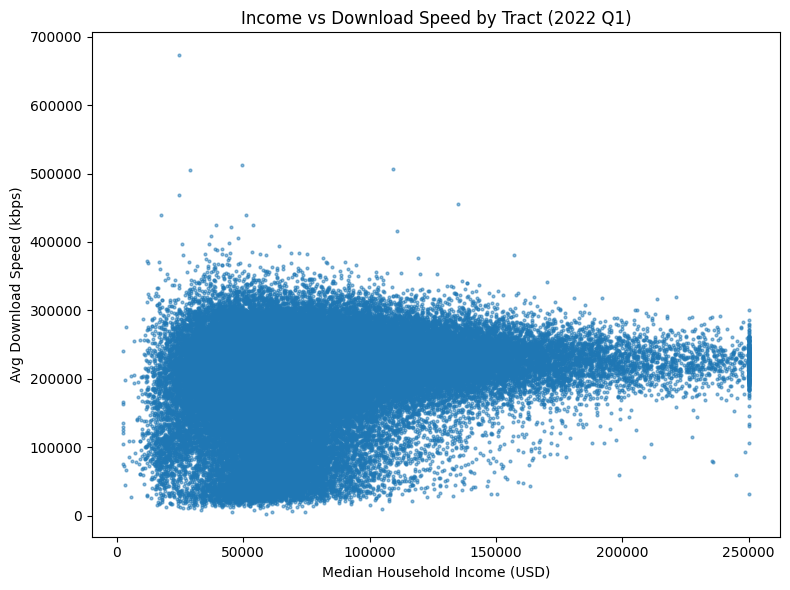

In [44]:
x_var = "median_income"
y_var = "avg_d_kbps_fixed"

t = df.copy()
t = t[t.avg_d_kbps_fixed < 10_000_000]

X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

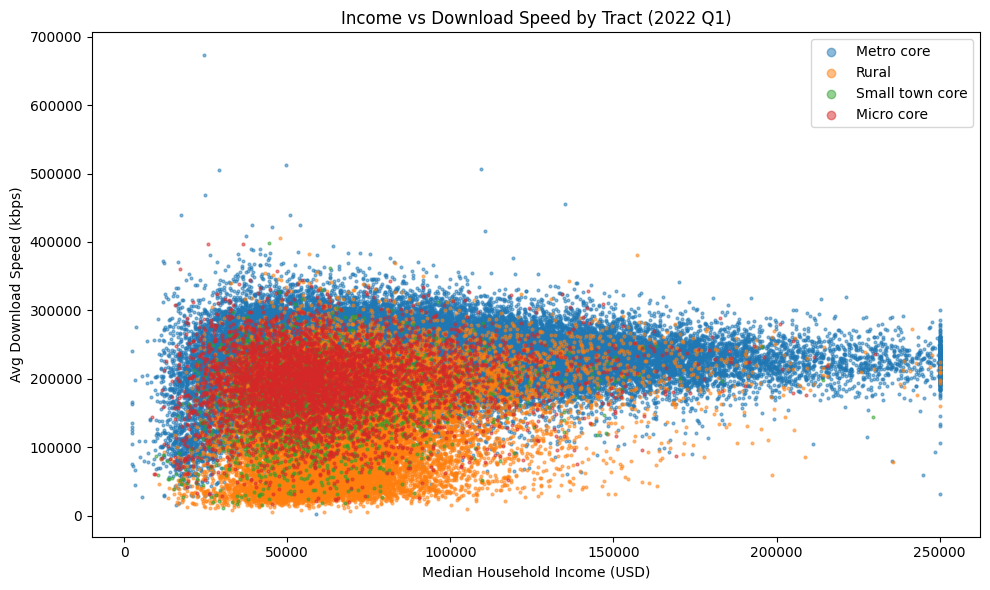

In [45]:
x_var = "median_income"
y_var = "avg_d_kbps_fixed"

t = df.copy()

# Create color map for urban_core_type
urban_types = t['urban_core_type'].unique()
colors = plt.cm.tab10(range(len(urban_types)))
color_map = dict(zip(urban_types, colors))

# Quick scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
for urban_type in urban_types:
    mask = t['urban_core_type'] == urban_type
    ax.scatter(t[mask][x_var], t[mask][y_var], 
               s=4, alpha=0.5, label=urban_type, color=color_map[urban_type])

ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
ax.legend(markerscale=3, loc='best')
plt.tight_layout()
plt.show()

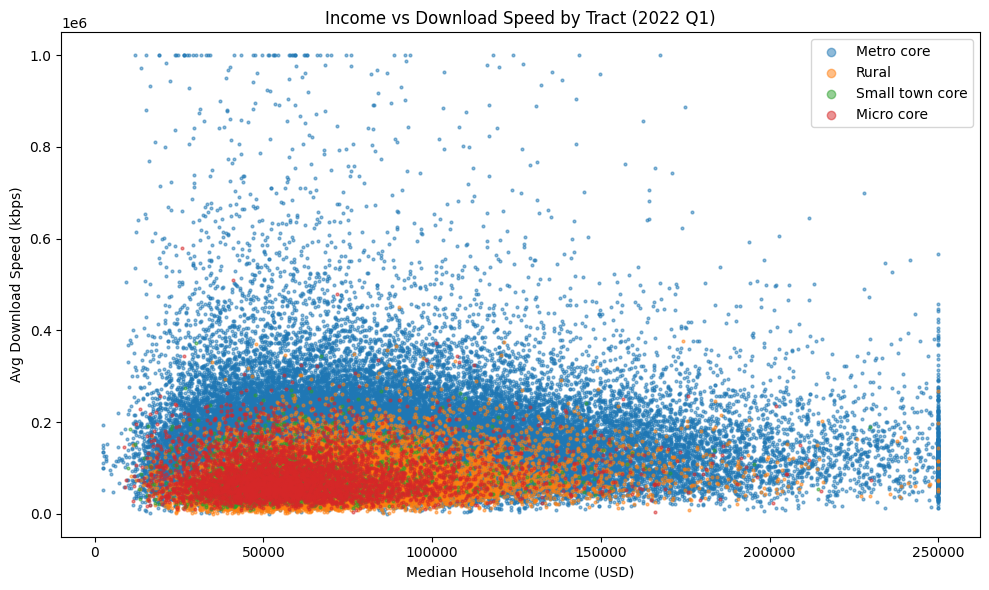

In [46]:
x_var = "median_income"
y_var = "avg_d_kbps_mobile"

t = df.copy()

# Create color map for urban_core_type
urban_types = t["urban_core_type"].unique()
colors = plt.cm.tab10(range(len(urban_types)))
color_map = dict(zip(urban_types, colors))

# Quick scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
for urban_type in urban_types:
    mask = t["urban_core_type"] == urban_type
    ax.scatter(
        t[mask][x_var],
        t[mask][y_var],
        s=4,
        alpha=0.5,
        label=urban_type,
        color=color_map[urban_type],
    )

ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
ax.legend(markerscale=3, loc="best")
plt.tight_layout()
plt.show()

In [47]:
(df.groupby("urban_core_type").avg_d_kbps_fixed.describe()/1000).round().astype(int)

,count,mean,std,min,25%,50%,75%,max
urban_core_type,,,,,,,,
Metro core,57,227,41,3,204,229,253,673
Micro core,5,192,51,17,162,196,226,398
Rural,18,130,68,5,72,127,183,405
Small town core,2,166,56,12,132,170,204,398


In [48]:
(df.groupby("urban_core_type").median_income.describe() / 1000).round().astype(int)

,count,mean,std,min,25%,50%,75%,max
urban_core_type,,,,,,,,
Metro core,57,85,43,2,55,77,107,250
Micro core,5,63,27,9,45,58,75,230
Rural,18,71,26,11,54,66,82,250
Small town core,2,60,23,10,45,56,71,230


In [49]:
import pandas as pd

url = "https://www.ooma.com/blog/average-us-internet-speeds-over-time/"
tables = pd.read_html(url)

# The "Average U.S. internet speeds by year" table is the last one on the page
# Headers are in row 1, data starts at row 3
t = tables[-1]
t.columns = t.iloc[0]  # Set row 1 as headers
t = t.iloc[2:].reset_index(drop=True)  # Data starts at row 3

# Convert speed columns to numeric, handling Kb/s and Mb/s suffixes
def parse_speed(speed_str):
    """Convert speed string with Kb/s or Mb/s suffix to numeric kbps"""
    if pd.isna(speed_str):
        return None
    speed_str = str(speed_str).strip()
    if 'Mb/s' in speed_str:
        return float(speed_str.replace('Mb/s', '').strip()) * 1000  # Convert Mb/s to Kb/s
    elif 'Kb/s' in speed_str:
        return float(speed_str.replace('Kb/s', '').strip())
    else:
        return float(speed_str)

# Apply conversion to speed columns (assuming columns are named like 'Download' and 'Upload')
for col in t.columns:
    if col != 'Year' and col is not None:
        t[col] = t[col].apply(parse_speed)

print(t)

0   Year     Speed
0   1993      14.4
1   1994      24.0
2   1995      27.5
3   1996      33.6
4   1997      34.3
5   1998      44.3
6   1999      56.0
7   2000     127.0
8   2001     200.0
9   2002     400.0
10  2003     800.0
11  2004     861.0
12  2005    1100.0
13  2006    1550.0
14  2007    3500.0
15  2008    5580.0
16  2009    7120.0
17  2010   10000.0
18  2011   10000.0
19  2012   15000.0
20  2013   15600.0
21  2014   31000.0
22  2015   32000.0
23  2016   39000.0
24  2017   30740.0
25  2018   43390.0
26  2019   54080.0
27  2020   89830.0
28  2021   99920.0
29  2022  129420.0
30  2023  138900.0
31  2024  209000.0
32  2025  214000.0


In [50]:
df.set_index('Year').plot()

KeyError: "None of ['Year'] are in the columns"

,Year,Speed
0,1993,14.4
1,1994,24.0
2,1995,27.5
3,1996,33.6
4,1997,34.3


# OLS Regression: Fixed Broadband Speed vs Income and Urban Core Type

Analyze how median income and urban core type (categorical variable) affect fixed broadband download speeds.

In [55]:
# OLS Regression: avg_d_kbps_fixed ~ median_income + urban_core_type
import statsmodels.formula.api as smf
import pandas as pd
from scipy.stats import zscore

# Prepare data - drop missing values and ensure proper types
t = df.copy()
t = t.dropna()

# Ensure numeric columns are float
t['avg_d_kbps_fixed'] = pd.to_numeric(t['avg_d_kbps_fixed'], errors='coerce')
t['median_income'] = pd.to_numeric(t['median_income'], errors='coerce')
t["median_income"] = np.log(t["median_income"])

# Standardize income to Z scores using scipy
t["median_income"] = zscore(t["median_income"], nan_policy='omit')
t["pop_density"] = zscore(pd.to_numeric(t["pop_density"]), nan_policy="omit")

# Drop any rows that became NaN after conversion
t = t.dropna()

model = smf.ols(
    "avg_d_kbps_fixed ~ median_income + pop_density + C(urban_core_type) + C(county)",
    data=t,
).fit(cov_type="HC3")

# Display results
print(model.summary())
print(f"\nNumber of observations: {len(t):,}")

                            OLS Regression Results                            
Dep. Variable:       avg_d_kbps_fixed   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     428.5
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:30:32   Log-Likelihood:            -9.8827e+05
No. Observations:               81291   AIC:                         1.977e+06
Df Residuals:                   80976   BIC:                         1.980e+06
Df Model:                         314                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
df.columns

Index(['GEOID', 'avg_d_kbps_fixed', 'avg_d_kbps_mobile', 'tests_fixed',
       'tests_mobile', 'NAME', 'population', 'acs_year', 'state', 'county',
       'tract', 'median_income', 'STUSPS', 'county_name', 'urban_core_type',
       'primary_ruca_desc', 'primary_dest_code', 'pop_density'],
      dtype='object')

In [56]:
# OLS Regression: avg_d_kbps_fixed ~ median_income + urban_core_type
import statsmodels.formula.api as smf
import pandas as pd
from scipy.stats import zscore

# Prepare data - drop missing values and ensure proper types
t = df.copy()
t = t.dropna()

# Ensure numeric columns are float
t["avg_d_kbps_mobile"] = pd.to_numeric(t["avg_d_kbps_mobile"], errors="coerce")
t["median_income"] = pd.to_numeric(t["median_income"], errors="coerce")
t["median_income"] = np.log(t["median_income"])

# Standardize income to Z scores using scipy
t["median_income"] = zscore(t["median_income"], nan_policy="omit")
t["pop_density"] = zscore(pd.to_numeric(t["pop_density"]), nan_policy="omit")

# Drop any rows that became NaN after conversion
t = t.dropna()

model = smf.ols(
    "avg_d_kbps_mobile ~ median_income + pop_density + C(urban_core_type) + C(county)",
    data=t,
).fit(cov_type="HC3")

# Display results
print(model.summary())
print(f"\nNumber of observations: {len(t):,}")

                            OLS Regression Results                            
Dep. Variable:      avg_d_kbps_mobile   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     304.7
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:40:54   Log-Likelihood:            -1.0334e+06
No. Observations:               81291   AIC:                         2.067e+06
Df Residuals:                   80976   BIC:                         2.070e+06
Df Model:                         314                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------